<a href="https://colab.research.google.com/github/yiyichanmyae/time_series/blob/main/2_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Statistical Forecasting on Synthetic Data

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [6]:
from os import setregid
def plot_series(time, series, format=".", start=0, end=None):
    """
    Visualizes time series data

    Args:
      time (array of int) - contains the time steps
      series (array of int) - contains the measurements for each time step
      format - line style when plotting the graph
      label - tag for the line
      start - first time step to plot
      end - last time step to plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))

    if type(series) is tuple:

      for series_num in series:
        # plot the time series data
        plt.plot(time[start:end], series_num[start:end], format)

    else:

      # plot the time series data
      plt.plot(time[start:end], series[start:end], format)

    # Label the x-axis
    plt.xlabel("Time")

    # Label the y-axis
    plt.ylabel("Value")

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()


def trend(time, slope=0):
    """
    Generates synthetic data that follows a straight line given a slope value.

    Args:
      time (array of int) - contains the time steps
      slope (float) - determines the direction and steepness of the line

    Returns:
      series (array of float) - measurements that follow a straight line
    """


    # Compute the linear series given the slope
    series = slope * time
    return series

def seasonal_pattern(season_time):
    """
    Just an arbitrary pattern ( can change as we wish)

    Args:
      season_time (array of float) - contains the measurements per time step

    Returns:
      data_pattern (array of float) -  contains revised measurement values according
                                  to the defined pattern
    """

    # Generate the values using an arbitrary pattern
    data_pattern = np.where(
        season_time < 0.4,
        np.cos(season_time * 2 * np.pi),
        1/ np.exp(3 * season_time))

    return data_pattern

def seasonality(time, period, amplitude=1, phase=0):
    """
    Repeats the same pattern at each period

    Args:
      time (array of int) - contains the time steps
      period (int) - number of time steps before the pattern repeats
      amplitude (int) - peak measured value in a period
      phase (int) - number of time steps to shift the measured values

    Returns:
      data_pattern (array of float) - seasonal data scaled by the defined amplitude
    """

    # Define the measured values per period
    season_time = ((time+phase) % period) / period

    # Generates the seasonal data scaled by the defined amplitude
    data_pattern = amplitude * seasonal_pattern(season_time)

    return data_pattern

def noise(time, noise_level=1, seed=None):
    """Generates a normally distributed noisy signal

    Args:
      time (array of int) - contains the time steps
      noise_level (float) - scaling factor for the generated signal
      seed (int) - number generator seed for repeatability

    Returns:
      noise (array of float) - the noisy signal
    """

    # Initialize the random number generator
    rdm = np.random.RandomState(seed)

    # Generate a random number for each time step and scale by the noise level
    noise = rdm.randn(len(time)) * noise_level
    return noise

## Generate the synthetic data

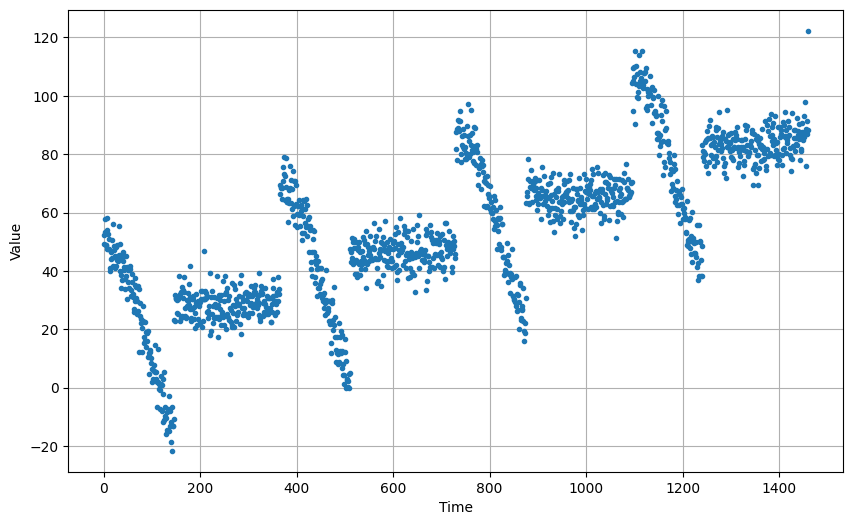

In [7]:
# Parameters
time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

# Update with noise
series += noise(time, noise_level, seed=42)

# Plot the results
plot_series(time, series)

## Split the Dataset

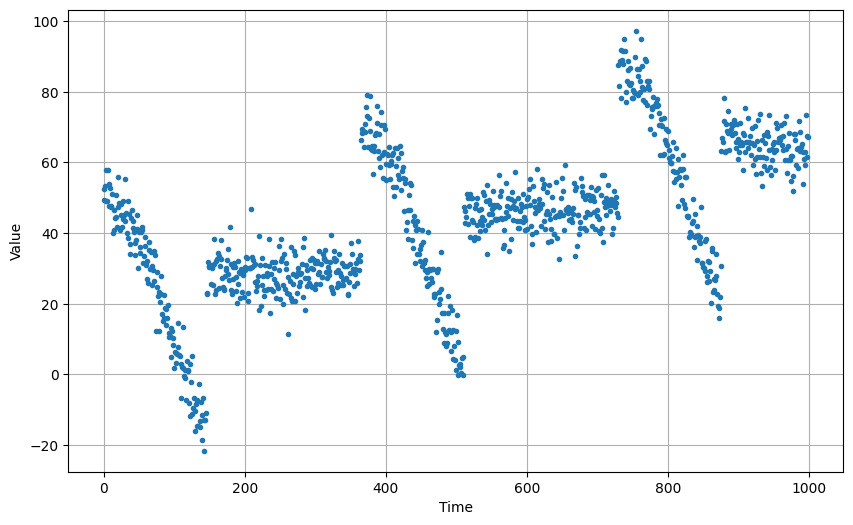

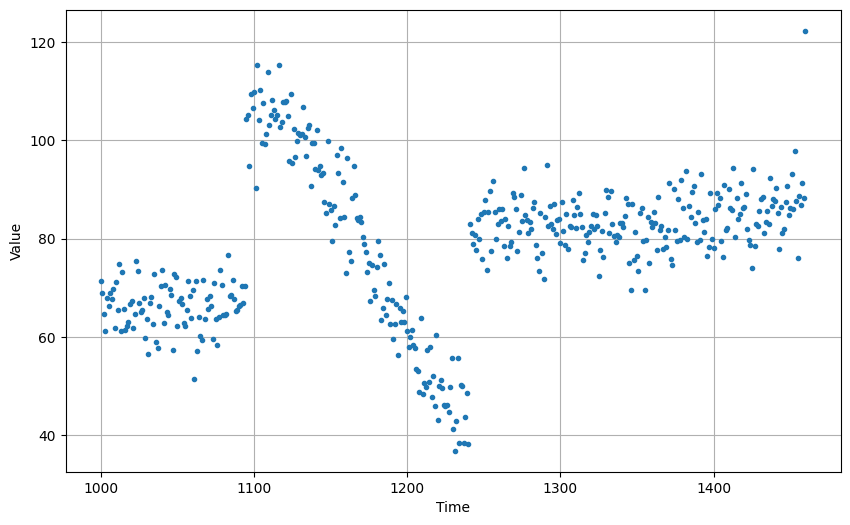

In [9]:
# Define the split time
split_time = 1000

# Get the train set
time_train  = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]

# Plot the train set
plot_series(time_train, x_train)

# Plot the validation set
plot_series(time_valid, x_valid)


## Naive Forecast



ground truth at time step 100: 109.84197998046875
prediction at time step 101: 109.84197998046875


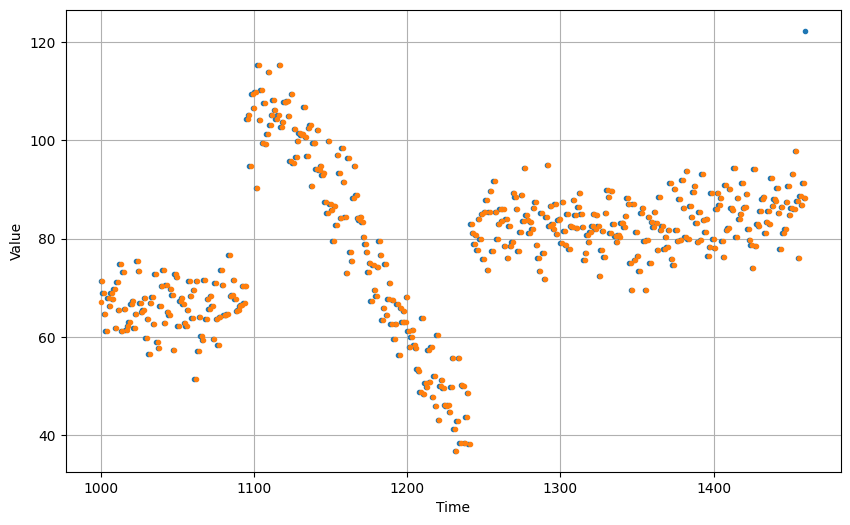

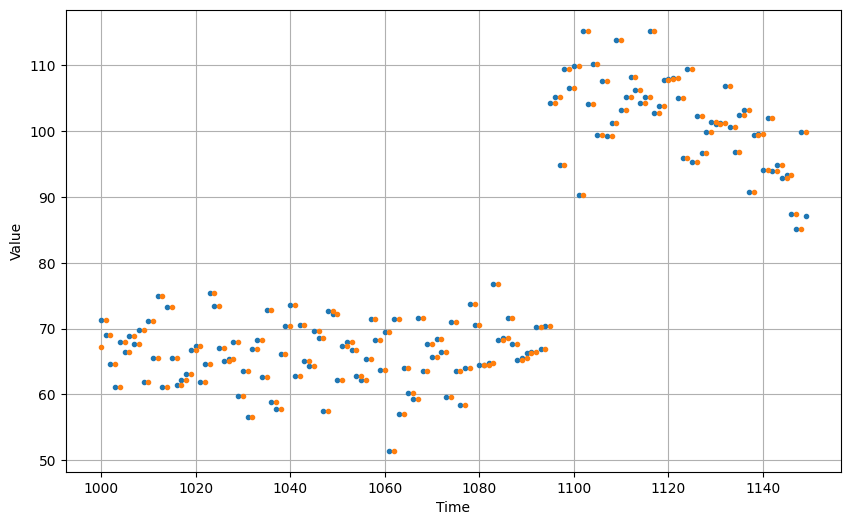

61.827534
5.937908


In [22]:
# Generate the naive forecast
naive_forecast = series[split_time -1 : -1]

# Define time step
time_step = 100

# Print values
print(f"ground truth at time step {time_step}: {x_valid[time_step]}")
print(f"prediction at time step {time_step + 1}: {naive_forecast[time_step + 1]}")

# Plot the results
plot_series(time_valid, (x_valid, naive_forecast))

# Zooming in
plot_series(time_valid, (x_valid, naive_forecast), start=0, end=150)

# Computing Metrics

print(tf.keras.metrics.mean_squared_error(x_valid, naive_forecast).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, naive_forecast).numpy())

# Moving Average

In [15]:
def moving_average_forecast(series, window_size):
    """Generates a moving average forecast

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to compute the average for

    Returns:
      forecast (array of float) - the moving average forecast
    """

    # Initialize a list
    forecast = []

    # Compute the moving average based on the window size
    for time in range(len(series) - window_size):
      forecast.append(series[time : time + window_size].mean())

    # Convert to a numpy array
    forecast = np.array(forecast)
    return forecast


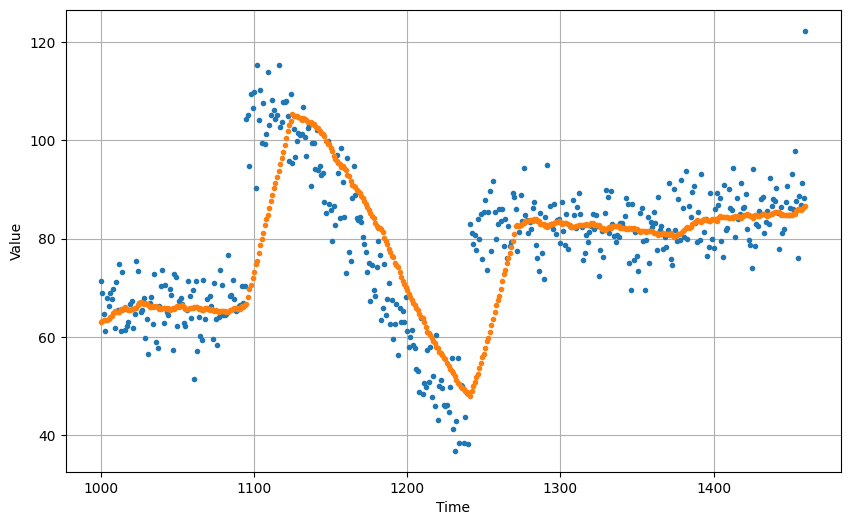

106.674576
7.142419


In [20]:
# Generate the moving average forecast
moving_avg = moving_average_forecast(series, 30)[split_time - 30:]

# Plot the results
plot_series(time_valid, (x_valid, moving_avg))

# Compute the metrics
print(tf.keras.metrics.mean_squared_error(x_valid, moving_avg).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, moving_avg).numpy())

## Differencing

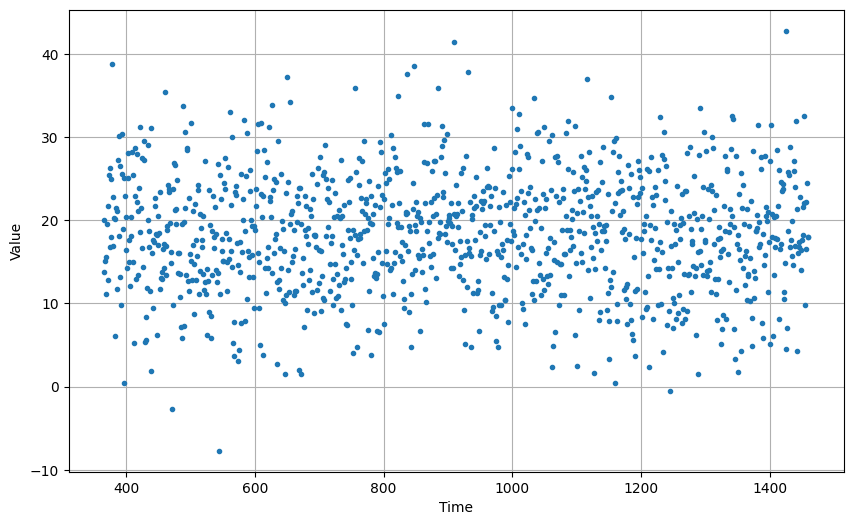

In [18]:
# Subtract the values at t-365 from original series
diff_series = (series[365:] - series[:-365])

# Truncate the first 365 time steps
diff_time = time[365:]

# Plot the results
plot_series(diff_time, diff_series)


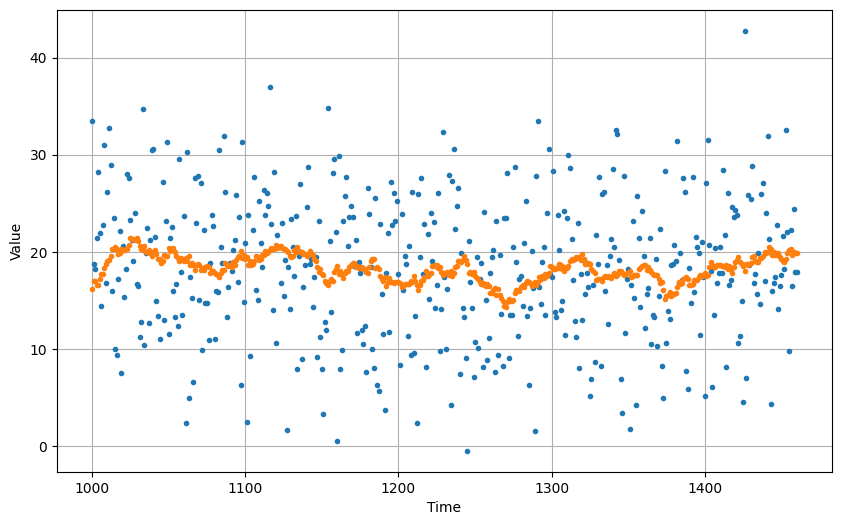

In [19]:
# Generate moving average from the time differenced dataset
diff_moving_avg = moving_average_forecast(diff_series, 30)

# Slice the predication points that corresponds to the validation set time steps
diff_moving_avg = diff_moving_avg[split_time - 365 - 30:]

# Slice the ground truth points that corresponds to the validation set time steps
diff_series = diff_series[split_time - 365:]

# Plost the results
plot_series(time_valid, (diff_series, diff_moving_avg))


## Smoothing

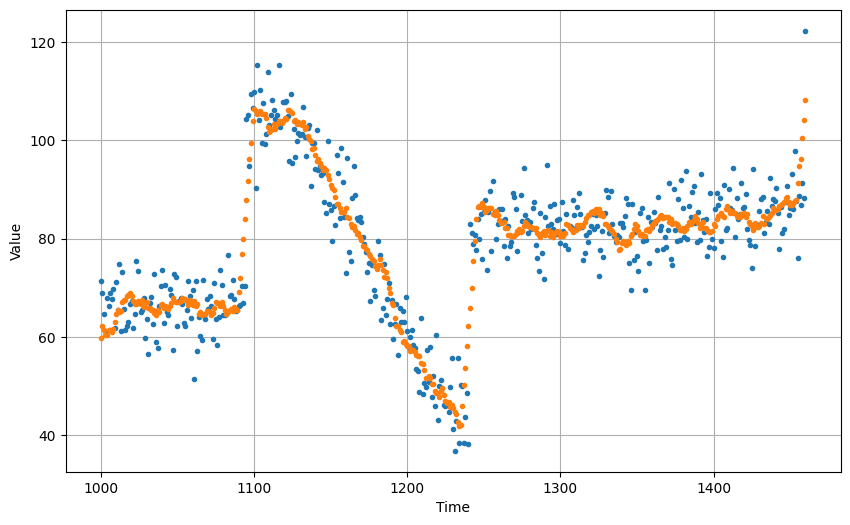

34.315723
4.6053295


In [21]:
# Smooth the original series before adding the time differenced moving average
diff_moving_avg_plus_smooth_past = moving_average_forecast(
    series[split_time - 370: -359],
    11
) + diff_moving_avg

# Plot the results
plot_series(time_valid, (x_valid, diff_moving_avg_plus_smooth_past))

# Compute the metrics
print(tf.keras.metrics.mean_squared_error(x_valid, diff_moving_avg_plus_smooth_past).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_smooth_past).numpy())